In [1]:
% matplotlib inline

In [8]:
import os

In [9]:
os.chdir("..")

In [10]:
import numpy as np
import scipy
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle
from tqdm import tqdm
from sampling.run_sampling import SamplingLogger

In [11]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [17]:
fold_idx = 6 # gujarat

In [18]:
greedy_sat = pickle.load(open("results/fold_%d/sampling_greedy_sat.pkl" % fold_idx, "rb"))
greedy_nosat = pickle.load(open("results/fold_%d/sampling_greedy_nosat.pkl" % fold_idx, "rb"))
random_sat = pickle.load(open("results/fold_%d/sampling_random_sat.pkl" % fold_idx, "rb"))
random_nosat = pickle.load(open("results/fold_%d/sampling_random_nosat.pkl" % fold_idx, "rb"))

In [19]:
df_train = pd.read_csv("results/fold_%d/sampling_train.csv" % fold_idx)
df_val = pd.read_csv("results/fold_%d/sampling_val.csv" % fold_idx)

In [20]:
print(len(df_train))

96


In [21]:
print(len(df_val))

97


In [22]:
opt_r2 = max(
  np.mean(np.array(random_sat.r2s_matrix)[:,-1]),
  np.mean(np.array(greedy_sat.r2s_matrix)[:,-1]),
  np.mean(np.array(random_nosat.r2s_matrix)[:,-1]),
  np.mean(np.array(greedy_nosat.r2s_matrix)[:,-1]),
)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


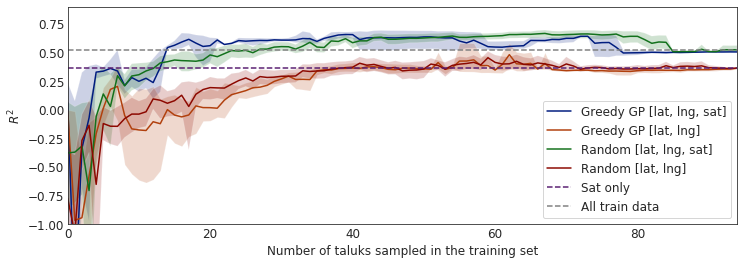

In [23]:
plt.figure(figsize=(12, 4))
sns.tsplot(greedy_sat.r2s_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
sns.tsplot(greedy_nosat.r2s_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(random_sat.r2s_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(random_nosat.r2s_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df_val["true"], df_val["pred"]), ls="--", color=plt_colors[4], label="Sat only")
plt.axhline(opt_r2, ls="--", color="grey", label="All train data")
plt.ylim(-1, 0.9)
plt.legend();

In [24]:
opt_mse = min(
  np.mean(np.array(random_sat.mses_matrix)[:,-1]),
  np.mean(np.array(greedy_sat.mses_matrix)[:,-1]),
  np.mean(np.array(random_nosat.mses_matrix)[:,-1]),
  np.mean(np.array(greedy_nosat.mses_matrix)[:,-1]),
)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


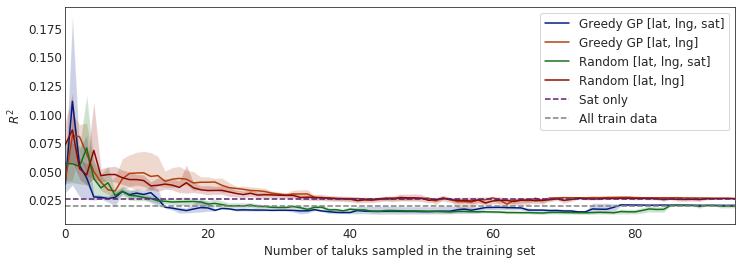

In [25]:
plt.figure(figsize=(12, 4))
sns.tsplot(greedy_sat.mses_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
sns.tsplot(greedy_nosat.mses_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(random_sat.mses_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(random_nosat.mses_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(mean_squared_error(df_val["true"], df_val["pred"]), ls="--", color=plt_colors[4], label="Sat only")
plt.axhline(opt_mse,ls="--", color="grey", label="All train data")
# plt.ylim(0, 0.01)
plt.legend();

In [26]:
opt_coeff = np.polyfit(np.r_[df_train["true"], df_val["true"]], 
                       np.r_[df_train["electrification"], df_val["electrification"]], deg=1)[0]

In [30]:
sat_coeff = np.polyfit(np.r_[df_train["pred"], df_val["pred"]],
                       np.r_[df_train["electrification"], df_val["electrification"]], deg=1)[0]

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


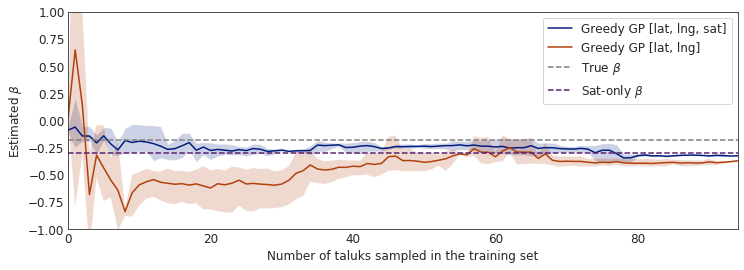

In [33]:
plt.figure(figsize=(12, 4))
sns.tsplot(greedy_sat.coeffs_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
sns.tsplot(greedy_nosat.coeffs_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
# sns.tsplot(random_sat.coeffs_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
# sns.tsplot(random_nosat.coeffs_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
# sns.tsplot(greedy_sat.coeffs_matrix_only_sampled, condition="Greedy, samples only", color=plt_colors[3], ci=95)
# sns.tsplot(random_nosat.coeffs_matrix_only_sampled, condition="Random, samples only", color=plt_colors[1], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("Estimated $\\beta$")
plt.axhline(opt_coeff, ls="--", color="grey", label="True $\\beta$")
plt.axhline(sat_coeff, ls="--", color=plt_colors[4], label="Sat-only $\\beta$")
plt.ylim(-1, 1)
plt.legend();

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


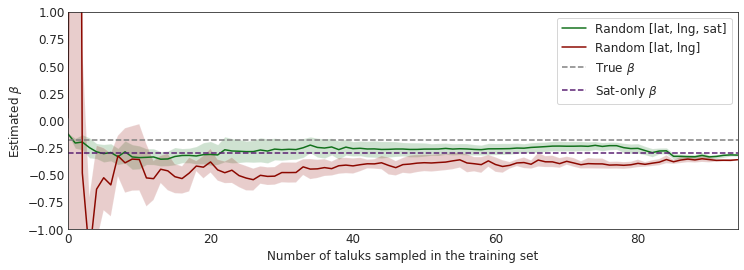

In [34]:
plt.figure(figsize=(12, 4))
# sns.tsplot(greedy_sat.coeffs_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
# sns.tsplot(greedy_nosat.coeffs_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(random_sat.coeffs_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(random_nosat.coeffs_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
# sns.tsplot(greedy_sat.coeffs_matrix_only_sampled, condition="Greedy, samples only", color=plt_colors[3], ci=95)
# sns.tsplot(random_nosat.coeffs_matrix_only_sampled, condition="Random, samples only", color=plt_colors[1], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("Estimated $\\beta$")
plt.axhline(opt_coeff, ls="--", color="grey", label="True $\\beta$")
plt.axhline(sat_coeff, ls="--", color=plt_colors[4], label="Sat-only $\\beta$")
plt.ylim(-1, 1)
plt.legend();

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


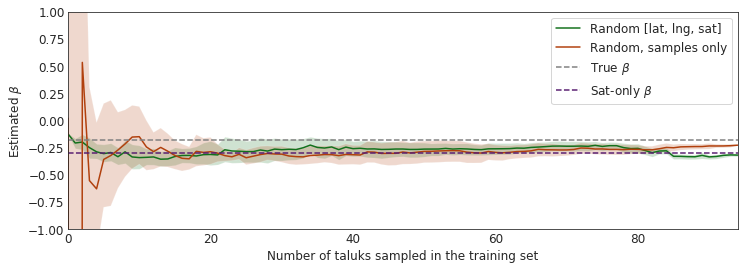

In [35]:
plt.figure(figsize=(12, 4))
# sns.tsplot(greedy_sat.coeffs_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
# sns.tsplot(greedy_nosat.coeffs_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(random_sat.coeffs_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
# sns.tsplot(random_nosat.coeffs_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
# sns.tsplot(greedy_sat.coeffs_matrix_only_sampled, condition="Greedy, samples only", color=plt_colors[3], ci=95)
sns.tsplot(random_nosat.coeffs_matrix_only_sampled, condition="Random, samples only", color=plt_colors[1], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("Estimated $\\beta$")
plt.axhline(opt_coeff, ls="--", color="grey", label="True $\\beta$")
plt.axhline(sat_coeff, ls="--", color=plt_colors[4], label="Sat-only $\\beta$")
plt.ylim(-1, 1)
plt.legend();